In [1]:
import os
import glob
import SimpleITK as sitk
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

# MONAI 관련 모듈 임포트
from monai.transforms import Compose,  ScaleIntensityRanged, ToTensorD
import pathlib
import torch
from typing import Dict, List, Tuple, Any, Mapping, Hashable

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os, json, warnings
import SimpleITK as sitk

from monai.data import DataLoader, Dataset
from monai.config import KeysCollection
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    ScaleIntensityd,
    RandAdjustContrastd,
    RandAffined,
    RandSpatialCropd,
    RandFlipd,
    Resize,
    MapTransform,
)


In [2]:
# SlidingWindowPatchDataset 클래스 수정
class SlidingWindowPatchDataset(Dataset):
    def __init__(self, root_dir: str, modality: str, patch_size: Tuple[int, int, int] = (128, 128, 0), overlap: float = 0.5, transform=None):
        """
        Args:
            root_dir: 데이터셋의 루트 경로.
            modality: 'ct' 또는 'cbct' 중 학습에 사용할 modality.
            patch_size: (width, height, depth) 형태의 패치 크기.
            overlap: 패치 간 겹치는 비율.
            transform: MONAI Compose 객체.
        """
        self.root_dir = root_dir
        self.modality = modality.lower()
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform # transform 인자 추가
        
        if self.modality not in ['ct', 'cbct']:
            raise ValueError("modality는 'ct' 또는 'cbct'여야 합니다.")
        
        self.file_list = []
        self._pre_calculate_patches()

    def _pre_calculate_patches(self):
        tasks = ['AB', 'HN', 'TH']
        for task in tasks:
            task_dir = os.path.join(self.root_dir, task)
            case_dirs = [d for d in os.listdir(task_dir) if os.path.isdir(os.path.join(task_dir, d))]
            
            for case_name in case_dirs:
                case_dir = os.path.join(task_dir, case_name)
                input_path = os.path.join(case_dir, f'{self.modality}.mha')
                mask_path = os.path.join(case_dir, 'mask.mha')
                
                if not (os.path.exists(input_path) and os.path.exists(mask_path)):
                    print(f"경고: {case_dir}에서 파일이 누락되었습니다. 이 케이스는 건너뜁니다.")
                    continue
                
                input_image = sitk.ReadImage(input_path)
                original_size = input_image.GetSize()
                original_width, original_height, original_depth = original_size[0], original_size[1], original_size[2]
                
                target_width, target_height = self.patch_size[0], self.patch_size[1]
                stride_x = int(target_width * (1.0 - self.overlap))
                stride_y = int(target_height * (1.0 - self.overlap))
                if stride_x == 0: stride_x = 1
                if stride_y == 0: stride_y = 1
                
                for y in range(0, original_height, stride_y):
                    for x in range(0, original_width, stride_x):
                        start_x = x
                        start_y = y
                        
                        if start_x + target_width > original_width:
                            start_x = original_width - target_width
                        if start_y + target_height > original_height:
                            start_y = original_height - target_height
                        
                        self.file_list.append({
                            'input': input_path,
                            'mask': mask_path,
                            'origin': (start_x, start_y, 0),
                            'size': (target_width, target_height, original_depth)
                        })

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        patch_info = self.file_list[idx]
        
        # SimpleITK 이미지 로드
        input_image = sitk.ReadImage(patch_info['input'])
        mask_image = sitk.ReadImage(patch_info['mask'])
        
        # 패치 추출
        cropper = sitk.ExtractImageFilter()
        cropper.SetIndex(patch_info['origin'])
        cropper.SetSize(patch_info['size'])
        
        input_patch = cropper.Execute(input_image)
        mask_patch = cropper.Execute(mask_image)
        
        # SimpleITK 이미지를 NumPy 배열로 변환
        input_array = sitk.GetArrayFromImage(input_patch)
        mask_array = sitk.GetArrayFromImage(mask_patch)
        
        # MONAI Transforms 적용을 위해 딕셔너리 형태로 묶음
        data = {
            'input': input_array,
            'mask': mask_array
        }

        # self.transform이 있다면 적용
        if self.transform:
            data = self.transform(data)

        return data

In [3]:
class ApplyMaskd(MapTransform):
    """Apply a mask to the input images."""
    def __init__(self, keys: KeysCollection, mask_key: str = "mask", allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.mask_key = mask_key

    def __call__(self, data):
        d = dict(data)
        mask = d[self.mask_key]
        inv_mask = 1.0 - mask
        for key in self.keys:
            if key in d:
                img = d[key]
                min_img = img.min()
                d[key] = img * mask + min_img * inv_mask
        return d


In [7]:
transforms = Compose(
    [
        ApplyMaskd(keys=['input'], mask_key="mask"),
        ScaleIntensityRanged(keys=['input'], a_min=-1024, a_max=3071., b_min=0.0, b_max=1.0, clip=True),
        ToTensorD(keys=['input', 'mask'])
    ]
)

# 2. Dataset과 DataLoader 인스턴스 생성
root_dir = 'VAL/Task2' 
ct_dataset = SlidingWindowPatchDataset(
    root_dir=root_dir,
    modality='ct',
    patch_size=(128, 128, 0),
    overlap=0.5,
    transform=transforms # 정의한 변환 파이프라인을 전달
)
ct_data_loader = DataLoader(ct_dataset, batch_size=4, shuffle=True, num_workers=4)

# 3. 데이터 로딩 확인
print(f"총 패치 개수: {len(ct_dataset)}")
first_batch = next(iter(ct_data_loader))
print("\nMONAI Transform이 적용된 배치 데이터 형태:")
print(f"  input: {first_batch['input'].shape}")
print(f"  mask: {first_batch['mask'].shape}")

경고: VAL/Task2/HN/overviews에서 파일이 누락되었습니다. 이 케이스는 건너뜁니다.
총 패치 개수: 7933

MONAI Transform이 적용된 배치 데이터 형태:
  input: torch.Size([4, 5, 128, 128])
  mask: torch.Size([4, 5, 128, 128])


Array shape: (312, 307, 1)


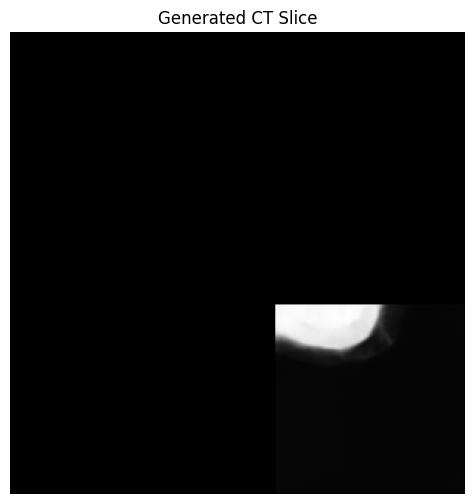

In [4]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# 파일 경로
mha_path = "/mnt/d/synthrad/TRAIN/2HNA050/0/0_generated.mha"

# MHA 파일 읽기
volume = sitk.ReadImage(mha_path)
array = sitk.GetArrayFromImage(volume)  # (D, H, W) 또는 (H, W)

# 출력 텐서 형태 확인
print("Array shape:", array.shape)

# 2D인지 3D인지에 따라 시각화
if array.ndim == 3:
    # 3D인 경우, 가운데 slice
    mid_slice = array[:, :, 0]
elif array.ndim == 2:
    # 이미 2D
    mid_slice = array
else:
    raise ValueError("Unsupported array shape")

# 시각화
plt.figure(figsize=(6, 6))
plt.imshow(mid_slice, cmap="gray")
plt.axis("off")
plt.title("Generated CT Slice")
plt.show()
